# **Date Loading**

In [1]:
!pip install tomotopy &> /dev/null # "& > /dev/null" install 결과 표시 숨김
!pip install konlpy &> /dev/null

In [2]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git &> /dev/null
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh &> /dev/null

In [3]:
import pandas as pd
import numpy as np

import tomotopy as tp
import pprint

import collections
import gensim
from konlpy.tag import Mecab
from konlpy.corpus import kolaw

import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/소셜빅데이터분석_2021/W12_coherence perplexity/df_sample.csv", encoding='UTF-8')
df.head()

,year,month,day,content,group
0,2013,9,2,한·일 두 정부의 외면으로 묻혀질 뻔했던 간토(關東)대지진 조선인 대학살이 오늘날 ...,Kyunghyang
1,2012,6,10,"2009년 77일간의 공장 점거농성과 강경진압, 소속 노동자의 37인 2646명 대...",Hankyoreh
2,2009,8,13,자유는 만물의 생명이요 평화인생의 행복이다 자유와 평화정신을 설파하고 실천한 만해 ...,Chosun
3,2018,8,30,지난해 스위스 제네바에서 열린 유엔 인권이사회 총회 뉴스 유엔기구가 지난 1년간 북...,Joongang
4,2002,10,12,노벨 평화상 수상자로 결정된 지미 카터는 퇴임 후의 행적이 더욱 아름다운 대통령으로...,Joongang


# Tokenizer
Mecab 품사 태그 : https://docs.google.com/spreadsheets/d/1-9blXKjtjeKZqsf4NzHeYJCrr49-nXeRF6D80udfcwY/edit#gid=589544265

In [6]:
mecab = Mecab()
tags = ['NNG', 'NNP']
stopwords = []

def Tokenizer(text):
    morphs = mecab.pos(text)
    pos = []

    for word, tag in morphs:
        if(len(word) < 2 and word not in stopwords): 
            continue
        if tag in tags:
            pos.append(word)

    return pos

# **Topic Coherence**

토픽 모델링을 구현할 때 토픽 개수에 따른 일관성 확인을 위한 검증 단계   
perplexity와 coherence 값을 비교하여 적절한 토픽값을 유추함   
* perplexity는 낮을수록, coherence는 높을수록 일반적으로 우수하다고 평가함
* 그러나 일반적으로 두 조건을 모두 충족하는 값을 찾는 경우는 거의 없음
* 토픽모델링은 파라미터 설정에 따라 얼마든지 값이 바뀌기 때문에 토픽 개수에서 정답은 없음(참고용으로만 활용해야 함)
* 이를 위해서는 토픽 모델링 이전의 전처리 단계를 꼼꼼하게 진행할 필요 있음

현재 tomotopy에서는 topic coherence를 확인할 수 있는 방법이 없음.   
따라서 tomotopy에서 실행한 lda 결과를 gensim의 자료구조 형태로 변환하여 topic coherence를 비교하는 절차를 거침

https://radimrehurek.com/gensim/models/coherencemodel.html

In [7]:
# tomotopy의 lda 결과를 gensim에서 활용가능한 자료구조 형태로 변환하는 함수

def get_coherence(model, coherence=None, topn=None, processes=None): # None으로 하면 자동으로 default...밑에서 값을 정해 줬으니, 정해진 값이 들어온다
    """
    model: tomotopy lda
    coherence: coherence 값을 구하는 알고리즘(u_mass 나 c_v 를 사용하는데 일반적으로 c_v 활용)
    topn: coherence 계산할 때 고려할 토픽 키워드
    processes: workers와 유사한 기능
    """

    # tomotopy 에서 토픽-키워드간 데이터 추출
    topics = []
    for k in range(model.k): #model.k에서 뽑는게 숫자이기 때문에 레인지를 쓴다...k에 해당되는 내용이 없고
        word_probs = model.get_topic_words(k, topn) #토픽에 해당되는 키워드에 대해 확률값을 넣어주는 것
        topics.append([word for word, prob in word_probs])
    
    # tomotopy에서 토픽-문서간 데이터 추출하여 gensim에서 활용가능한 코퍼스 구현
    texts = []
    corpus = []
    for doc in model.docs: #여긴 왜 range를 안넣나?...실제 문서의 내용을 가져와야 하기 때문에...리스트 형태로 있는 문서의 내용을 가져온다...doc는 내용이 있다...
        words = [model.vocabs[token_id] for token_id in doc.words] #doc.words가 어디서 왔나? '토모토피에서 자동적으로 정해 놓은 변수이다' 
        texts.append(words) #젠심 단계에서 lda를 하기 위한 신문기사...토모토미에서 해놓은 것은 되돌리는 것....
        freqs = list(collections.Counter(doc.words).items()) #왜 .items()가 붙은거지? collections.Counter는 반드시 젠심은 아니다...collectios 라이브러리에서...items() 함수는 튜플(x=y...검찰=100)...전체를 list형태로..
                  #list를 통해서 각각 문서들에 대해서 진행함.....list는 전체를 하나의 집합으로 묶어 준다...
        corpus.append(freqs)
    
    # gensim 형태의 자료구조 형태로 변환
    id2word = dict(enumerate(model.vocabs)) #model.vocabs는 변수 아닌가? enumerate는 전체 문서에서 특정 단어가 언급된 숫자를 말한다...전체 오천개에서 검찰=1500번 이런 식으로....dict는 튜플형태로??
    dictionary = gensim.corpora.dictionary.Dictionary.from_corpus(corpus, id2word) # tomotopy에 활용된 키워드들을 (단어, 빈도) 구조의 형태로 변환
    
    cm = gensim.models.coherencemodel.CoherenceModel(
        topics=topics,
        texts=texts,
        corpus=corpus,
        dictionary=dictionary,  
        coherence=coherence, # (바로 아래에 있는 'c_v', 10, 5를 넣는 것임...)
        topn=topn,
        processes=processes,
    )

    return cm.get_coherence() #그냥 cm을 리턴하는게 아니고 여기에 또 .get_coherence()를 넣는것? 왜?; 이건 리턴했는데, 아래에서 전혀 사용되지 않네? return을 안하면 해당하는 값을 가져오지 않는다..cm은 속성값이 나온다...

In [8]:
# perplexity, coherence 값을 확인하는 함수

def compute_coherence_values(start, limit, step):
    for i in range(start, limit, step):
        mdl = tp.LDAModel(k=i)
        for text in df['content']:  
            mdl.add_doc(Tokenizer(text))  
        mdl.train(iter=50, workers=0)
        coherence_value = get_coherence(mdl, coherence='c_v', topn=10, processes=5)

        print('Topic: {}\tLog-likelihood: {}\tPerplexity: {}\tCoherence: {}'\
        .format(
            i,
            mdl.ll_per_word,
            mdl.perplexity,
            coherence_value
            )
        )
        #coherence_values = []
        #perplexities = []     
        coherence_values.append(coherence_value) 
        perplexities.append(mdl.perplexity) 

In [9]:
limit = 100 # maximum topic number
start = 10; # minimum topic number
step = 10; # step unit

coherence_values = []
perplexities = []

# coherence 확인은 gensim의 프로세싱을 따르기 때문에 시간이 상당히 소요됨
compute_coherence_values(start, limit, step)

Topic: 10	Log-likelihood: -8.770614839532989	Perplexity: 6442.132124467673	Coherence: 0.504321981085943
Topic: 20	Log-likelihood: -8.78317554727292	Perplexity: 6523.560189788263	Coherence: 0.5423375964465178
Topic: 30	Log-likelihood: -8.767695359679303	Perplexity: 6423.351877131615	Coherence: 0.5880696201740281
Topic: 40	Log-likelihood: -8.760872876806792	Perplexity: 6379.677821120569	Coherence: 0.581245197357801
Topic: 50	Log-likelihood: -8.750077673411315	Perplexity: 6311.1782997993105	Coherence: 0.5908900045790662
Topic: 60	Log-likelihood: -8.767925602124757	Perplexity: 6424.830975644913	Coherence: 0.5821682966532932
Topic: 70	Log-likelihood: -8.754513860486503	Perplexity: 6339.2380605586695	Coherence: 0.5797534162636255
Topic: 80	Log-likelihood: -8.738534915635451	Perplexity: 6238.748720130753	Coherence: 0.5842122430866036
Topic: 90	Log-likelihood: -8.751928634609742	Perplexity: 6322.8708638514945	Coherence: 0.5858076067471967


In [10]:
x = range(start, limit, step)

mdl_check = pd.DataFrame(list(zip(x, perplexities, coherence_values)), columns=['Num Topics', 'Perplexity', 'Coherence']) # from np.array ro pd.dataframe

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf40176690>,
      dtype=object)

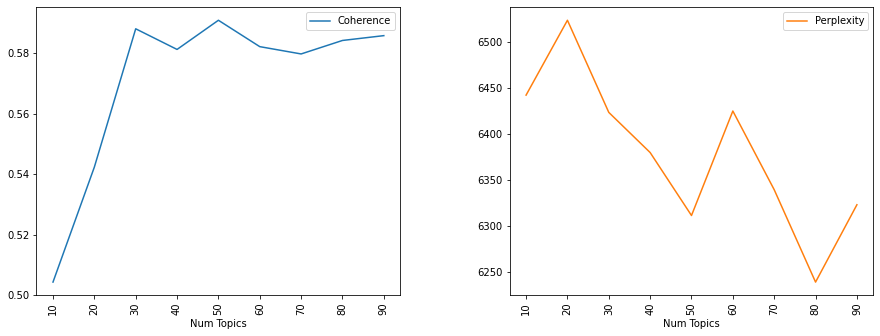

In [11]:
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2) # nrows=1 ? ncols=2?..2개 그림 배치를 어떻게?....행1개 열2개...subplots이 쪼개는 것....fig는 figsize에 관한 것....15.5가 아래 눈에 보이는 사이즈.....(가로..세로)

plt.subplots_adjust(left=0.125, #여백 간의 관계를 adjust.... 그림이 여려개 있을때 공간과 여백 설정....left=.125...반으로 쪼갠 것 내에서 배치를 어떻게...wspace는 두 그림 사이의 거리...hspace는 필요가 없다...
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.5)

pd.pivot_table(mdl_check, values=["Perplexity", "Coherence"],index="Num Topics")\
    .plot(kind='line', rot=90, ax=ax, subplots=True)  # perplexity와 coherence의 위치? \표시는 .plot 과 연결. .plot을 어떻게 그릴거냐? 선 그래프...rotation 가로축 로테이션..위의 ax.
                                                      # subplots=True는 두개를 나눈다....
                                                      # \.plot??. 아래 상단에 나오는 array....는 뭐지? 없애도 되지 않나?

In [12]:
# 위 그래프를 확인한 후 k에 적절한 토픽값 입력(여기서는 그냥 임의로 10을 넣음)

mdl = tp.LDAModel(k=10)
for text in df['content']:
    mdl.add_doc(Tokenizer(text))
mdl.train(iter=100, workers=0)

# **Look inside deeply**

In [13]:
pprint.pprint(mdl.get_topic_words(8, top_n=10))

[('미국', 0.02941875532269478),
 ('중국', 0.01777663826942444),
 ('대통령', 0.008850382640957832),
 ('세계', 0.008774414658546448),
 ('인권', 0.007520940154790878),
 ('영국', 0.006856218911707401),
 ('시위', 0.006723274942487478),
 ('정부', 0.006476378533989191),
 ('테러', 0.0060965376906096935),
 ('국가', 0.005954097490757704)]


In [14]:
#top_docs = [[] for _ in range(10)] # 관련이 높은 문서들을 아래의 리스트(꺽쇠) 안에 넣어준다.......루프 만드는 방식이 두개 있는데...1. for방식의 루프...2. 이러한 방식의 루프(nested list).....

In [15]:
top_docs = [[] for _ in range(mdl.k)] # 문서와 토픽간의 연관성을 보여주는 변수가 필요하다..변수를 넣어줄 공간 만듦...첫번째 토픽과 연관성이 높은 문서를 넣어줄 공간...빈꺽쇠는 빈공간... - 아무것도 없는 빈공간을 넣어준다..
                                        # -는 아무것도 안받은거구...이것을 꺽쇠에 넣어주니 결과적으로 꺽쇠에는 아무것도 안들어간다.....이건 nested list라 불리임! 

for doc in mdl.docs:
    top_docs[doc.get_topics(top_n=1)[0][0]].append(doc) # 전체 document에 대해 최우선 토픽 번호를 매칭 (토픽값은 아니고 토픽값만 가져온다...)

In [16]:
# print(mdl.docs[0].get_topics(top_n=1)[0]) # 0번째 document에서 가장 높은 비중을 차지하는 토픽과 토픽값 확인....top_n=1도 함수다! 제일 토픽값이 높은 것을 가져와라....토픽값이 제일 높은 토픽을 가져와서 퓨플형태로...
                                            # top_n=3 [0] 이렇게 하면....높은 3개를 가져오는데 그 중에서 0번째를 가져오라....[0] [0] 토픽 변호만 나오고..[0] [1]을 하면 토픽값이 나온다.... 
# print(mdl.docs[0].get_topics(top_n=1)[0][0]) 토픽 번호만 추출

In [17]:
for k in range(mdl.k):
    print('Num docs belonging to topic #%d: %d' % (k, len(top_docs[k]))) # %d 정규식인데....%자리에 무엇을 넣어주겠다...% 뒤에 세팅을 해준다....top_docs로 나온 문서들의 숫자를 넣어준다.....

Num docs belonging to topic #0: 255
Num docs belonging to topic #1: 262
Num docs belonging to topic #2: 559
Num docs belonging to topic #3: 413
Num docs belonging to topic #4: 1061
Num docs belonging to topic #5: 807
Num docs belonging to topic #6: 97
Num docs belonging to topic #7: 598
Num docs belonging to topic #8: 607
Num docs belonging to topic #9: 341


In [18]:
top_docs[8][0:9]

[<tomotopy.Document with words="방글라데시 가혹 군사 독재자 후세인 모하마드 에르 샤드 대통령 최근 감옥살이 마감 방글라데시 대법원 대통령 시절 직권 남용 부정부패 혐의 수감 에르 샤드 하급 법원 원심 파기 보석 판결 혐의 군수용 레이더 장비 구명보트 정부 입찰 관련 수뢰 군장 암살 연루 에르 샤드 셰이크 총리 칼레다 지아 총리 야당 연합 규모 반정부 시위 권좌 징역 감옥 형기 절반 보석 결정 소식 에르 샤드 진실 승리 결과 자신 결백 주장 방글라데시 국민 부정부패 독재자 대법원 판결 의아 야당 인권 단체 이번 판결 연립 정당 연합 에르 샤드 소속 당인 야당 모종 정치 거래 결과 비난 최대 야당 방글라데시 민족주의 지아 당수 에르 샤드 석방 총리 지난해 총선 이후 연립 정권 참가 티야 선물 인권 연합 단체 아드 히카르도 성명 보석 신청 처리 사법부 독립성 의심 야당 반응 나라 에르 샤드 총선 옥중 당선 저력 회기 의회 출입 허용 생활 참모총장 승진 쿠데타 당시 집권당 방글라데시 민족주의 축출 권력 장악 대통령 당선 재선 축출 동안 가혹 군사 독재 체제">,
 <tomotopy.Document with words="아르헨티나 악명 전쟁 당시 아기 납치 개입 군사 독재자 호르헤 비델라 현지 시간 아르헨티나 법원 선고 방청석 희생자 유가족 실현 사법 정의 눈시울 법원 이날 선고 재판 군사 독재 시절 좌파 운동가 아기 조직 강탈 개입 비델라 대통령 중형 선고 군정 마지막 집권자 레이날도 비뇨 혐의 선고 아기 납치 좌파 학생 노동 운동가 지식인 살해 실종 아르헨티나 군부 전쟁 과정 재판 제출 증거 임신 체제 여성 수도 부에노스아이레스 악명 고문장 소인 해양 기술 학교 억류 팔목 수갑 머리 두건 아기 대부분 출산 직후 아기 얼굴 알몸 군용기 바닷물 추정 아기 좌파 뿌리 계획 일환 장교 강제 입양 인권 단체 마요 광장 할머니 추산 검사 가족 단체 회장 에스텔라 로토 군사 정권 아기 강탈 조직 자행 통신 비델라 대통령 지난주 법정 아기 모친 테러리즘

# Visualize


In [19]:
topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs) # lda하게 되면 실제 분석에 쓰인 단어들을 vocab 변수에 넣어줌....
term_frequency = mdl.used_vocab_freq # 전체문서에서 각각의 사용된 단어의 빈도를 의미

In [20]:
df_lda = df.reset_index() # 전체 파일이 리스트 처리가 되어 있는데...sampling을 하게 되면 (10만개 중에 5천개)...5천개에 indexing이 원래 붙어 있는데 이걸 풀어준다.....샘플링이 안됐으니 필요 없음....

In [21]:
df_topic = pd.DataFrame.from_records(doc_topic_dists) # from np.array ro pd.dataframe
df_topic.columns = ['Topic 01', 'Topic 02', 'Topic 03', 'Topic 04', 'Topic 05', 'Topic 06', 'Topic 07', 'Topic 08', 'Topic 09', 'Topic 10']
df_topic.head()

,Topic 01,Topic 02,Topic 03,Topic 04,Topic 05,Topic 06,Topic 07,Topic 08,Topic 09,Topic 10
0,0.080560,0.038355,0.001428,0.001148,0.135978,0.022315,0.000451,0.102298,0.000878,0.616589
1,0.477354,0.016316,0.191687,0.069458,0.126148,0.007293,0.016257,0.077700,0.000241,0.017546
2,0.392880,0.066449,0.002777,0.108117,0.020103,0.010819,0.000878,0.223387,0.107592,0.066998
3,0.079485,0.001229,0.010413,0.002128,0.353083,0.445183,0.000837,0.003310,0.102579,0.001752
4,0.141761,0.040315,0.001232,0.087703,0.005304,0.348039,0.000389,0.109931,0.239218,0.026107


In [22]:
df_lda = pd.concat([df_lda, df_topic], axis=1) # 두 df을 열 단위로 합치기....pd.comcat 여러개 데이터 프레임을 합쳐주는 함수...df_lda는 원래 lda한 파일이고 이것을 인덱싱만 풀어준거구...이것과 위에서 만든 df_topic합친거다..
                                               # axis = 1 캄럼을 합치는 방식으로, 일종의 merge하는 방식으로 합치는 거다...... 
test = df_lda.drop(['month', 'day', 'content', 'index'], axis = 1) # 필요없는 칼럼....axis = 1 는 열을 의미하므로 열에 해당되는 것을 없애라는 의미
test.head()

,year,group,Topic 01,Topic 02,Topic 03,Topic 04,Topic 05,Topic 06,Topic 07,Topic 08,Topic 09,Topic 10
0,2013,Kyunghyang,0.080560,0.038355,0.001428,0.001148,0.135978,0.022315,0.000451,0.102298,0.000878,0.616589
1,2012,Hankyoreh,0.477354,0.016316,0.191687,0.069458,0.126148,0.007293,0.016257,0.077700,0.000241,0.017546
2,2009,Chosun,0.392880,0.066449,0.002777,0.108117,0.020103,0.010819,0.000878,0.223387,0.107592,0.066998
3,2018,Joongang,0.079485,0.001229,0.010413,0.002128,0.353083,0.445183,0.000837,0.003310,0.102579,0.001752
4,2002,Joongang,0.141761,0.040315,0.001232,0.087703,0.005304,0.348039,0.000389,0.109931,0.239218,0.026107


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf43683cd0>,
      dtype=object)

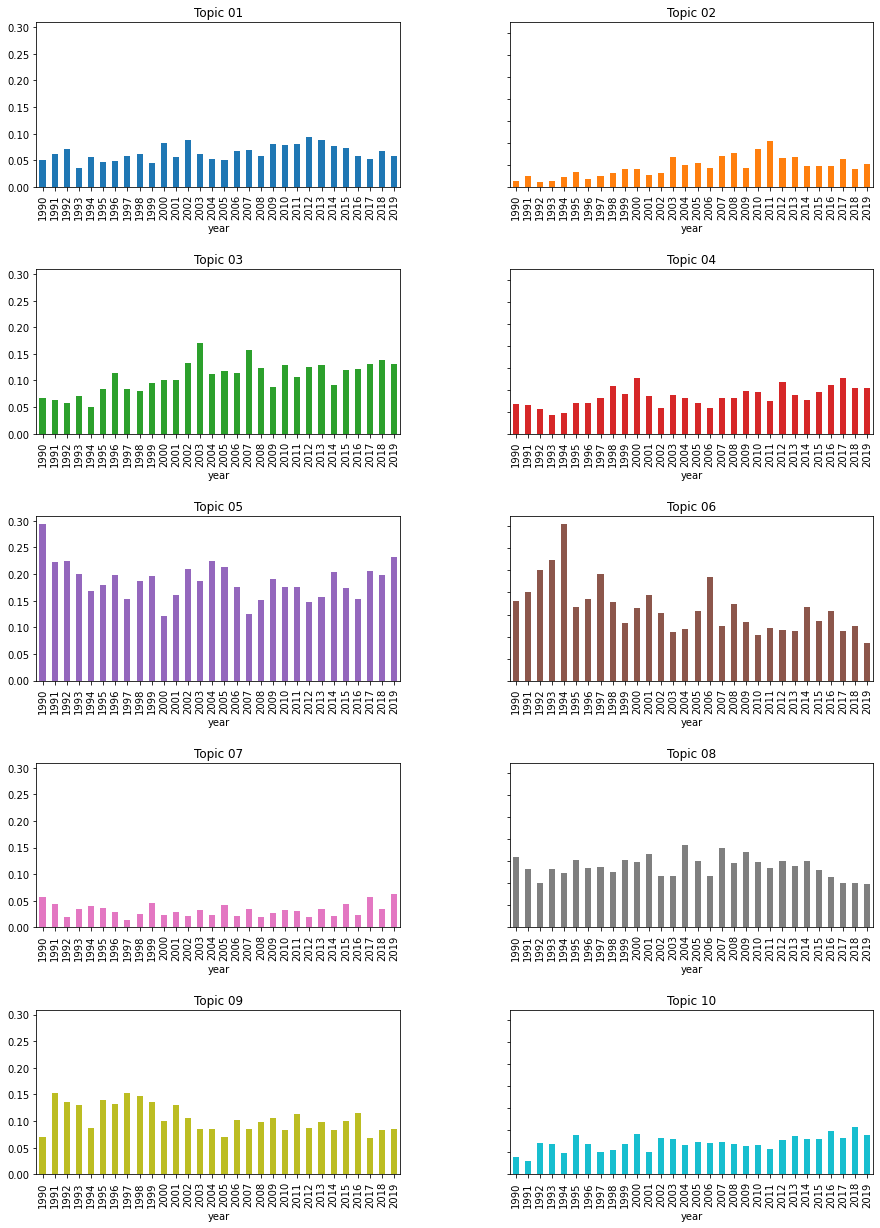

In [23]:
fig, ax = plt.subplots(figsize=(15,20), nrows=5, ncols=2, sharey='col') #sharey='col'은 그래프의 축을 결정해 주는 것....값이 입력이 들어가면 indexing을 연도...토픽값....y축을 share하고...col은 세로로 나온 값들을 지칭...

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.5)

pd.pivot_table(test, values=["Topic 01", "Topic 02", "Topic 03", "Topic 04", "Topic 05", "Topic 06", "Topic 07", "Topic 08", "Topic 09", "Topic 10"],
               index="year", aggfunc="mean")\
               .plot(kind='bar', rot=90, ax=ax, subplots=True, legend=None) #년도별로 각토픽값을 평균내는 것...legend는 꺼두고....

In [24]:
test_mean = test.groupby(['year','group']).sum() #test로 만들어 놓은 것을 신문사와 연도별로 나눠서....
test_mean['Mean'] = test_mean.mean(axis=1)
test_mean.head()

Topic 01  Topic 02  Topic 03  ...  Topic 09  Topic 10  Mean
year group                                     ...                          
1990 Chosun      0.327749  0.029587  0.806488  ...  0.760236  0.343179   1.0
     Hankyoreh   0.760185  0.086117  1.175574  ...  0.550792  0.537841   1.5
     Joongang    1.060058  0.382072  0.689634  ...  1.350755  0.365703   1.3
     Kyunghyang  0.334030  0.130345  0.598712  ...  0.737722  0.708633   1.1
1991 Chosun      0.349809  0.170465  0.457686  ...  1.833707  0.169939   1.1

[5 rows x 11 columns]

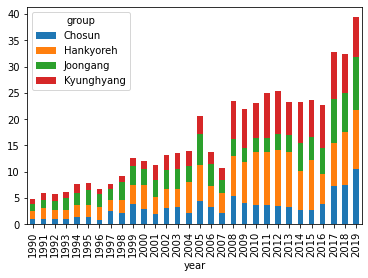

In [25]:
# 연도별+신문사별 토픽값의 평균

topic_group = test_mean.groupby(['year','group']).mean()['Mean']\
    .unstack('group')\
    .plot.bar(rot = 90, stacked=True)  # 스택을 풀어줄 인덱싱 부분이 group(신문사 부분)
                                       # stack=True를 안해 주면 연도별로 신문사가 따로 배치되므로, 해줘야 함

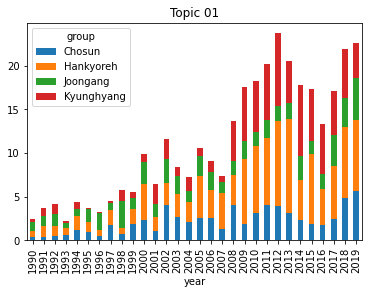

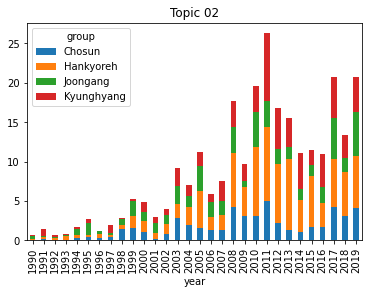

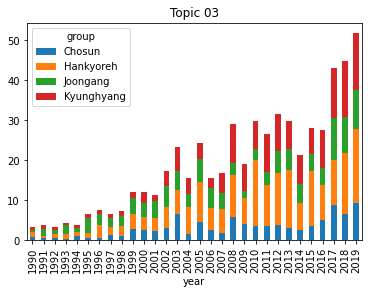

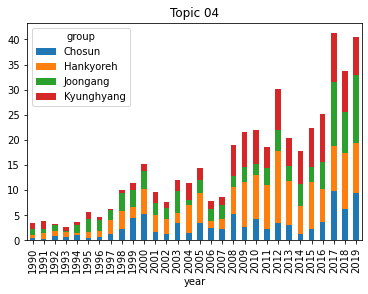

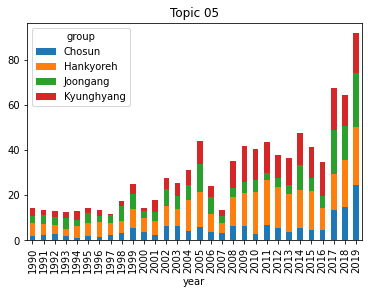

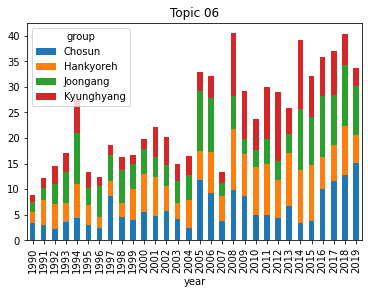

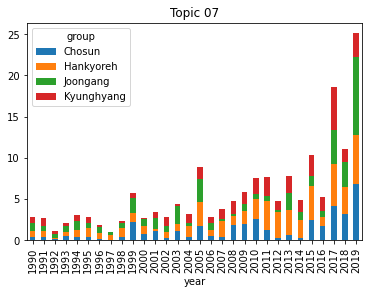

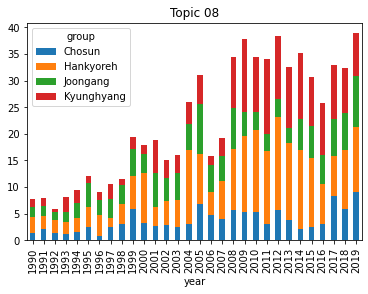

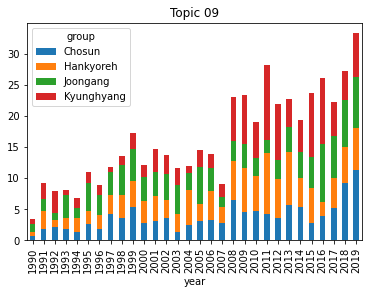

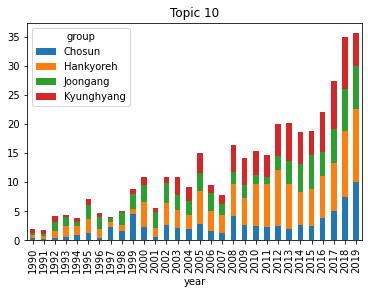

In [26]:
topic = list(["Topic 0" + str(i) if i < 10 else "Topic " + str(i) for i in range(1, 11)]) # list 안에는 명칭을 넣어준다....Topic 0으로 넣어야 Topic 01이 1로 나옴....str(i) i를 문자로 인식한다...
                                                                                          # 숫자, 문자 같이 넣어줄때, 숫자를 리스트로 바꿔줘야 함....

for i in topic:
    test_mean.groupby(['year', 'group']).sum()[i].unstack(level='group').plot.bar(rot = 90, stacked=True, title=(i)) # 각 토픽별로 연도별 신문사 토픽값의 총계를 stacked bar 형태로 제시함